#### PARAMETERS USED:
<b>Dataset and K varies</b> <br>

##### These parameters are tuned to best possible extent
1. thresh (opt = 0.3)
2. alpha_weight_avg (opt = 0.6)
3. per in LLE (opt = 0.5)
4. percent in GetCutOffDistMod (opt = 0.7)
5. val2 in Correcting_wrong_clustering (opt = 20)
6. val3 in Correcting_wrong_clustering (opt = 15)
7. percent1 in Correcting_wrong_clustering (opt = 0.8)
8. percent2 in Correcting_wrong_clustering (opt = 0.16)
9. percent3 in Correcting_wrong_clustering (opt = 0.10)
10. percent4 in Correcting_wrong_clustering (opt = 0.01)
11. algo for NN = kd_tree
13. KVal in Outlier Postprocessing (opt = 3% of dataset size)
14. percent5 in Outlier Postprocessing (opt = 0.01)

In [1]:
import math
import time
import csv
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
from statistics import mean
from operator import itemgetter
from collections import deque
from collections import defaultdict
from validclust import dunn
from sklearn.metrics.pairwise import pairwise_distances
from sklearn .metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn import metrics

In [2]:
start = time.time()

In [3]:
data_path = r"E:\JUPYTER NOTEBOOK\Aggregation.csv"
Ground_Truth_data_path=r"E:\ISI\GROUND TRUTHS CLUSTERING\Aggregation_gt.csv"
K = 25            ## Actually K-1 neighbors are considered. Remember              #### Imp
#25 #20 #10

with open(data_path, 'r') as f:
    data1 = np.genfromtxt(f, delimiter=',')   
Dimension = data1.shape[1]
#data1=data1/np.linalg.norm(data1)
print(len(data1))
print("Dimension: ",Dimension)
thresh = 0.3                                                                       #### Imp
alpha_weight_avg = 0.6
algo = 'ball_tree' #'kd_tree' 

Outlier_Detection = False #True 
Clustering = False #True

788
Dimension:  2


In [4]:
# Calculate the nearest neighbors, the density of point_i and density of its K neighbors
nbrs_ddcal = NearestNeighbors(n_neighbors=K, algorithm=algo).fit(data1)
distances_ddcal, indices_ddcal = nbrs_ddcal.kneighbors(data1)
# print(indices_ddcal)

Hash_Map = {i:0 for i in range(len(data1))}
labels = {i:0 for i in range(len(data1))}
density = []
for i in range(len(data1)):
    density.append([sum(distances_ddcal[i])/(K-1), data1[i], max(distances_ddcal[i]), indices_ddcal[i][1:], i])
    Hash_Map[i] = density[i]

In [5]:
# Distance-Density Value; Datapoint; Radius; k-nearest neighbors; idx_number
# 0: 0.45; (25,5); 0.2; [1,2,3,4,5]; 0

density.sort(key = itemgetter(0), reverse = False)
#print(density[:3])

In [6]:
# Function to calculate the weighted moving average
def numpy_ewma_vectorized_v2(values, alpha):
    #values = np.array(values)
    span = (2/alpha) - 1
    df = pd.DataFrame(values)
    return df.ewm(span=span).mean().iloc[-1][0]

In [7]:
# LLE: Locally linear Embedding
def LLE(data, K): #, data_point_Idx):
    row=len(data)
    #print(row)
    dimension=len(data[0])
    #print(dimension)
    neighbors= K
    W=np.zeros((row, row))
    count_pts = 0

    hash_map = {value:np.array([]) for value in range(len(data))}

    for i in range(row):
        D_i=np.array(data-data[i, :])
        #print(D_i)
        distance=(D_i**2).sum(1)
        #print(distance)
        nearest_neighbor=np.argsort(distance)[1:(neighbors+1)]
        #print(nearest_neighbor)
        D_nbrs=D_i[nearest_neighbor, :]
        #print(D_nbrs)
        ##Q=np.dot(D_nbrs, D_nbrs.T)
        Q=np.matmul(D_nbrs, D_nbrs.T)
        #print(Q)
#         t=np.trace(Q)
#         r=0.001*t
        r = 0.001 * float(Q.trace())
        if(neighbors>=dimension):
#             sig2 = (np.linalg.svd(D_i,compute_uv=0))**2
#             r = np.sum(sig2[dimension:])
            Q=Q+(r*np.identity(neighbors))
#             Q.flat[::neighbors+1] += r
        ##w=np.linalg.solve(Q, np.ones(neighbors))
        w=np.linalg.solve(Q, np.ones(neighbors))
        
        w = w/sum(w)
        ##w=w/sum(w)
        #print(i, w)
        W[i, nearest_neighbor]=w

        # My code
        temp = []
        for ele in w:
            #print(ele)
            #if ele != 0:
            temp.append(ele)
            temp.sort(reverse = True)
            hash_map[i] = np.array(temp) 
            
#     I=np.identity(row)
#     M=I-W
        if (count_pts+1) % 100 == 0:
            print("****************Computed LLE for {0} points****************".format(count_pts+1))
        count_pts += 1

    per = 0.5 #0.6 #0.3 #0.5 #0.2 #0.05 #0.1
    store_K = defaultdict()

    for j in range(len(data)):
        count = 0
        for i in range(1, len(hash_map[j])):
            #print(((1/neighbors) - (dec_per*(1/neighbors))), ((1/neighbors) + (dec_per*(1/neighbors))))
            if round((abs(hash_map[j][i-1] - hash_map[j][i])/abs(hash_map[j][i-1]))*100,1) <= per:
                count += 1
        store_K[j] = count
        
    # print(store_K)
    for key in store_K:
        store_K[key] += 1
    return store_K

    # return store_K[data_point_Idx] + 1  # +1 because all neighbouring algorithms consider the datapoint itself to be a part
                                          # of its neighbour

In [8]:
start4 = time.time()
# Optimization: Instead of calling the LLE for each point, we try to make it constant time
LLE_lookup = {}
LLE_lookup = LLE(data1, K)

print("time taken = ",time.time()-start4," sec")

****************Computed LLE for 100 points****************
****************Computed LLE for 200 points****************
****************Computed LLE for 300 points****************
****************Computed LLE for 400 points****************
****************Computed LLE for 500 points****************
****************Computed LLE for 600 points****************
****************Computed LLE for 700 points****************
time taken =  0.6068243980407715  sec


In [9]:
# """
# DFS Based Approach:

# However due to the maximum recursion depth constraint in Python Programming language
# this is not a very good approach. The BFS one above is a better solution.
# Typically it will fail for large datasets. 
# """

# def NovelClus(Parent, Hash_Map, idx, dataset, K, list_of_parents, labels, thresh, cluster_num, can_form_cluster):
#     #print(Parent[1], idx)
    
#     print("Cluster =", cluster_num)

#     while idx <= K-2:

#         Density_Parent = Parent[0]
#         Radius = Parent[2]
#         Child_Idx = Parent[3][idx] 
#         Child = Hash_Map[Child_Idx]
#         Child_Datapoint = Child[1]

#         # if child is already labelled then return
#         if labels[Child_Idx] > 0:
#             idx += 1
#             continue
            
        
#         neigh = NearestNeighbors(radius = Radius)
#         neigh.fit(dataset)
#         rng = neigh.radius_neighbors([Child_Datapoint])
#         #print(rng[0]) 

#         Density_Child = sum(rng[0][0])/len(rng[0][0])

#         # if dis-density threshold criteria is satisfied
#         if Density_Parent not in list_of_parents:
#             list_of_parents.append(Density_Parent)
#         data_parent = np.array(list_of_parents, dtype=np.float64)
#         weighted_density = numpy_ewma_vectorized_v2(data_parent, alpha_weight_avg)
#         print("Density of Parent =", weighted_density)
#         print("Density of Child = ", Density_Child)
#         numerator = abs(weighted_density - Density_Child)
#         denominator = weighted_density
#         print("Weighted Density =", numerator/denominator)
        
#         if numerator/denominator <= thresh:
#             labels[Child_Idx] = cluster_num
#             can_form_cluster[0] = [True]
#             NovelClus(Child, Hash_Map, 0, dataset, K, list_of_parents, labels, thresh, cluster_num, can_form_cluster)

#         # else term Child as "Anomaly" and return
#         else:
#             #print("\n")
#             labels[Child_Idx] = -1
#             idx += 1
#             continue
            

In [10]:
"""
BFS based Approach: 

It takes care of the maximum recursion depth constraint in Python programming Language.
This however may take more time than DFS
"""

def NovelClus_FF(Parent, Hash_Map, dataset, K, list_of_parents_queue, labels, thresh, cluster_num, can_form_cluster, alpha_weight_avg):
    ##print("Cluster =", cluster_num)
    
    # We make use of a Deque for both side operation
    Queue = deque()
    
    # Append from left the Parent Node
    Queue.appendleft(Parent)
    
    
    # While Queue is not Null:
        # Queue extracts the first Node
        # We check if k children of Node satisfies the density criterion
        # if a child satisfies, it is pushed into the Queue from the end; else it is termed -1 and left
    
    while Queue:
        # Pop from the right end
        Parent = Queue.pop()
        
            
        # Getting important information from Parent
        Density_Parent = Parent[0]
        Radius = Parent[2]
        #Child_Idx = Parent[3][idx] 
        Child_Idx_array = Parent[3]   # [94,  32, 117, .... 100, 118]
        #Child = Hash_Map[Child_Idx]
        #Child_Datapoint = Child[1]
        
        # Update the list_of_parents for the weighted moving average
        list_of_parents = list_of_parents_queue.pop() + [Density_Parent] 
        #print("LoP =", list_of_parents)
        
        
        Child_array = []
        Child_Datapoint_array = []
        for Child_Idx in Child_Idx_array:
            Child_array.append(Hash_Map[Child_Idx])
            Child_Datapoint_array.append(Hash_Map[Child_Idx][1])  
        
        
        # For each Parent find which child satiesfies the density threshold criterion
        ##print("Number of Children Nodes =", len(Child_Idx_array), "\n")
        for i in range(len(Child_Idx_array)):
            
            Child = Child_array[i]
            Child_Idx = Child[-1]             ##Child_Idx_array[i]
            Child_Datapoint = Child[1]        ##Child_Datapoint_array[i]
            
            # Base case: if child is already labelled in cluster then ignore
            if labels[Child_Idx] > 0:
                #print("Child is already labelled!!")
                continue
                
            neigh = NearestNeighbors(radius = Radius)
            neigh.fit(dataset)
            rng = neigh.radius_neighbors([Child_Datapoint])
            #print(rng[0])
            
            Density_Child = sum(rng[0][0])/len(rng[0][0])
            
            #print("No. of Parent =",len(list_of_parents))
            
            data_parent = np.array(list_of_parents) #, dtype=np.float64)
            weighted_density = numpy_ewma_vectorized_v2(data_parent, alpha_weight_avg)  #O()??
            #print("Density of Parent =", weighted_density)
            #print("Density of Child = ", Density_Child)
            numerator = abs(weighted_density - Density_Child)
            denominator = weighted_density
            #print("Weighted Density =", numerator/denominator)
            
            
            if numerator/denominator <= thresh:
                labels[Child_Idx] = cluster_num
                
                list_of_parents_queue.appendleft(list_of_parents)
                       
                # Update the information for this child
                Child[0] = Density_Child
                Child[2] = max(rng[0][0])
                Child[3] = rng[1][0]
                
                Queue.appendleft(Child)
                
                # Update the hashmap OLD
                ##Hash_Map[Child[-1]] = Child
                
                # Update the hashmap NEW
                temp_dict = {Child[-1]:Child}
                Hash_Map.update(temp_dict)
                ##################################
                
            
                # The Parent can form a cluster of its own
                can_form_cluster[0] = [True]
                
                
            else:
                #print("Possible Anomaly!!")
                labels[Child_Idx] = -1
            
        

In [11]:
def update_nbrs(data1, idx, K, algo): # 70
    nbrs_ddcal = NearestNeighbors(n_neighbors=K, algorithm=algo).fit(data1)
    distances_ddcal, indices_ddcal = nbrs_ddcal.kneighbors(data1)

    density_mod = []
    density_mod.append([sum(distances_ddcal[idx])/(K-1), data1[idx], max(distances_ddcal[idx]), indices_ddcal[idx][1:], idx])
    
    density_mod.append([sum(distances_ddcal[i])/(K-1), data1[i], max(distances_ddcal[i]), indices_ddcal[i][1:], i])
    # density_cpy.append([sum(distances_ddcal[i])/(K-1), data1[i], max(distances_ddcal[i]), indices_ddcal[i][1:], i])
    
    return density_mod[0] #, density_mod[0]


In [12]:
data_idx = 0
cluster_num = 0
cluster_centers = []
hold_cluster_val = cluster_num ####


for data_idx in range(len(data1)):  #O(n)
    
    if (data_idx + 1) % 100 == 0:
        print("**************************Computed {} Datapoints**************************".format(data_idx+1))
    idx = 0
    list_of_parents_queue = deque()
    list_of_parents_queue.appendleft([])
    
    if labels[density[data_idx][-1]] == 0: #<= 0:
        cluster_num += 1
        labels[density[data_idx][-1]] = cluster_num
        can_form_cluster = [False]
        
        
        # Update information for the Parent node
        #   0                         1         2        3                    4
        # Distance-Density Value; Datapoint; Radius; k-nearest neighbors; idx_number
        
        
        # print(density[data_idx][-1])
        # break
        
        ## Modification ##############
        # print(density[data_idx])
        # print("\n\n")
        
        ##K_mod = LLE(data1, K, density[data_idx][-1])   #O(n)
        K_mod = LLE_lookup[density[data_idx][-1]]      #O(1) Optimized One
        #print("K modified: ",K_mod) # Can be uncommented for better intuition
        
        # Old One
        ##density[data_idx], Hash_Map[density[data_idx][-1]] = update_nbrs(data1, density[data_idx][-1], K_mod, algo)
        # print(density[data_idx])
        # break
        #########################################
        
        # New One
        density[data_idx] = update_nbrs(data1, density[data_idx][-1], K_mod, algo)
        temp_dict = {density[data_idx][-1]:density[data_idx]}
        #########################################
        
        NovelClus_FF(density[data_idx], Hash_Map, data1, K_mod, list_of_parents_queue, labels, thresh, cluster_num, can_form_cluster, alpha_weight_avg)
        # Time complexity of this Function:
        
        
        # Visualization: For higher dimensions this time complexity can be ignored
        """
        if Dimension <= 2:
            plt.figure(figsize=(8,8))
            for i in range(len(data1)):
                if labels[i] == cluster_num:
                    plt.scatter(data1[i][0],data1[i][1],c='pink')
                elif labels[i] == -1:
                    plt.scatter(data1[i][0],data1[i][1], c='yellow')
                else:
                    plt.scatter(data1[i][0], data1[i][1],c='blue')
            plt.scatter(density[data_idx][1][0], density[data_idx][1][1], c='red',s=200, marker = '+')
            plt.show()
        """

         
        # If the last Parent Node cannot form a clusterof its own then it is a part of a cluster with only 1 datapoint
        # which means " a possible Anomaly"
        # then change its label to -1 and reduce the cluster num by 1
        if can_form_cluster[0] == False:
            labels[density[data_idx][-1]] = -1
            cluster_num = hold_cluster_val  ####
        else:
            cluster_centers.append([density[data_idx][1].tolist(), cluster_num])
            hold_cluster_val += 1  ####


**************************Computed 100 Datapoints**************************
**************************Computed 200 Datapoints**************************
**************************Computed 300 Datapoints**************************
**************************Computed 400 Datapoints**************************
**************************Computed 500 Datapoints**************************
**************************Computed 600 Datapoints**************************
**************************Computed 700 Datapoints**************************


<ipython-input-11-e2b5461170ac>:6: RuntimeWarning: invalid value encountered in double_scalars
  density_mod.append([sum(distances_ddcal[idx])/(K-1), data1[idx], max(distances_ddcal[idx]), indices_ddcal[idx][1:], idx])
<ipython-input-11-e2b5461170ac>:8: RuntimeWarning: invalid value encountered in double_scalars
  density_mod.append([sum(distances_ddcal[i])/(K-1), data1[i], max(distances_ddcal[i]), indices_ddcal[i][1:], i])
<ipython-input-11-e2b5461170ac>:6: RuntimeWarning: invalid value encountered in double_scalars
  density_mod.append([sum(distances_ddcal[idx])/(K-1), data1[idx], max(distances_ddcal[idx]), indices_ddcal[idx][1:], idx])
<ipython-input-11-e2b5461170ac>:8: RuntimeWarning: invalid value encountered in double_scalars
  density_mod.append([sum(distances_ddcal[i])/(K-1), data1[i], max(distances_ddcal[i]), indices_ddcal[i][1:], i])
<ipython-input-11-e2b5461170ac>:6: RuntimeWarning: invalid value encountered in double_scalars
  density_mod.append([sum(distances_ddcal[idx])/(

In [13]:
# Following print statements can be uncommented for better intuition
# print(cluster_centers)
# print("\n", len(cluster_centers))

In [14]:
# Function corrects the wrong clustering
def Correcting_wrong_clustering(labels, cluster_centers, data1):  
    cluster_labels = []
    for key in labels:
        cluster_labels.append(labels[key])
    
    Hash_Map_2 = dict()
    X_label = dict()
    
    for i in range(len(data1)): 
        if labels[i] == -1:
            continue
        if labels[i] in Hash_Map_2:
            Hash_Map_2[labels[i]] += 1
            X_label[labels[i]] = X_label[labels[i]] + [data1[i].tolist()]
        else:
            Hash_Map_2[labels[i]] = 1
            X_label[labels[i]] = [data1[i].tolist()]
            
    #print("\nHASH MAP\n", Hash_Map_2)

    for key in Hash_Map_2:
        temp = Hash_Map_2[key]
        for idx in range(len(cluster_centers)):
            if cluster_centers[idx][1] == key:
                break
        Hash_Map_2[key] = [temp, cluster_centers[idx][0]]
        
        
    # Function to find Intra Cluster Distance    
    def IntraClusterMetric(X):
        Intra_Clus_Dist = 0
        for i in range(len(X)):
            Intra_Clus_Dist += (sum(euclidean_distances(X, [X[i]]))[0])/(len(X)-1)
        return Intra_Clus_Dist/(len(X)-1)
           
    
    for key in X_label:
        X = X_label[key]
        Intra_metric = IntraClusterMetric(X)
        Hash_Map_2[key] = Hash_Map_2[key] + [Intra_metric]  
    
    #print("Hash_Map_2\n",Hash_Map_2,"\n")
    
    clusnum_card = sorted(Hash_Map_2.items(), key=lambda kv:(kv[1], kv[0]), reverse = False)
    cluster_center_new = []
    for ele in clusnum_card:
        cluster_center_new.append(np.array(ele[1][1]))   

    ## Following print statements can be uncommented for better intuition
    # print(Hash_Map_2)
    # print("\nAfter Sorting ")
    # print(clusnum_card)
    # print("\nOnly cluster centers")
    # print(cluster_center_new)
    
    
    K1 = len(cluster_centers)
    nbrs = NearestNeighbors(n_neighbors=K1, algorithm='auto').fit(cluster_center_new)
    distances, indices = nbrs.kneighbors(cluster_center_new)
    #print(indices,"\n")
    #print(distances)

    
    def GetCutoffDistMod(cluster_centers):
        percent = 0.7
        i = 0
        j = 1
        Count = 0
        Sum = 0
        while i < len(cluster_centers)-1:
            while j < len(cluster_centers):
                Sum += math.dist(cluster_centers[i], cluster_centers[j])
                j += 1
                Count += 1
            i += 1
            j = i + 1
        Count = max(Count, 1)
        return math.ceil(Sum/Count)*percent
    
    
    #print(clusnum_card)
    
    #print("\n\n")
    dist_val = GetCutoffDistMod(cluster_center_new)
    val2 = 20
    val3 = 15
    percent1 = 0.8
    percent2 = 0.16
    percent3 = 0.10
    percent4 = 0.02

    # Format of clus_to_change: [curr_clus, clus_to_be]
    clus_to_change = []
    for i in range(len(clusnum_card)-1):
        # We are not considering till the last term since,
        # last term is the most dense and biggest among all 
        # the other clusters. It cannot be merged with others
        
        j = 1
        cardinality_of_self = Hash_Map_2[clusnum_card[i][0]][0]
        Intra_Clus_Self = Hash_Map_2[clusnum_card[i][0]][2]
        cardinality_of_neighbor = Hash_Map_2[clusnum_card[indices[i][j]][0]][0]
        Intra_Clus_Neigh = Hash_Map_2[clusnum_card[indices[i][j]][0]][2]
        
        #print(cardinality_of_self, cardinality_of_neighbor)
        while cardinality_of_self >= cardinality_of_neighbor and j < len(clusnum_card)-1:
            #print("YES")
            j += 1
            #print("j=",j)
            cardinality_of_neighbor = Hash_Map_2[clusnum_card[indices[i][j]][0]][0]  #-1
            Intra_Clus_Neigh = Hash_Map_2[clusnum_card[indices[i][j]][0]][2]

        # cardinality_of_self = Hash_Map_2[clusnum_card[i][0]]
        # cardinality_of_neighbor = Hash_Map_2[clusnum_card[indices[i][j]][0]][0]
        # print(cardinality_of_neighbor)
    
        ## Following print statements can be uncommented for better intuition
        # print("Cluster number", clusnum_card[i][0], "Cardinality ", Hash_Map_2[clusnum_card[i][0]][0])
        # print("Neighbor Cluster number", clusnum_card[indices[i][j]][0], "Cardinality ", Hash_Map_2[clusnum_card[indices[i][j]][0]][0])
        # print("Intra_Clus_Self", Intra_Clus_Self, "Intra_Clus_Neigh ", Intra_Clus_Neigh)
        # print("Intra Val Lower =", (Intra_Clus_Neigh - percent1*Intra_Clus_Neigh), "Intra Val Higher =", (Intra_Clus_Neigh + percent1*Intra_Clus_Neigh))
        # print("Percent1*CNeigh", int(percent1*cardinality_of_neighbor))
        # print("Percent2 =", (cardinality_of_self/cardinality_of_neighbor))
        # print("val3", val3)
        # print("Or condition", abs(cardinality_of_self - cardinality_of_neighbor), "val2", val2)
        # print("Distances between self and neighbor", int(round(distances[i][j],0)), "Dist_val", dist_val)
        
        
        # Using a boolean merge to keep a track if the self cluster is merged or not
        # Unless and until the cluster is merged, it is processed through every if condition
        merged = False
        
        # If cardinality of self and cardinality of neighbor are both less than a given threshold
        # where the threshold is very very small; say 10
        if merged == False:
            if cardinality_of_self <= val2 and cardinality_of_neighbor <= val2:
                # Distance checking here isn't necessary
                curr_clus = clusnum_card[i][0]
                clus_to_be = clusnum_card[indices[i][j]][0]
                clus_to_change.append([curr_clus, clus_to_be])
                Hash_Map_2[clusnum_card[indices[i][j]][0]][0] += cardinality_of_self
                #print("Merged 1st condition")
                merged = True  # made True so that we donot need to process it over other if conditions
        
        # If cardinality of self is less than 16% of cardinality of neighbor 
        if merged == False:
            if (cardinality_of_self/cardinality_of_neighbor) <= percent2 and cardinality_of_self <= val3:
                if int(round(distances[i][j],0)) <= dist_val:
                    curr_clus = clusnum_card[i][0]
                    clus_to_be = clusnum_card[indices[i][j]][0]
                    clus_to_change.append([curr_clus, clus_to_be])
                    Hash_Map_2[clusnum_card[indices[i][j]][0]][0] += cardinality_of_self
                    #print("Merged 2nd condition")
                    merged = True  # made True so that we donot need to process it over other if conditions
                
        # If Cardinality of self > val3 but is less than percent6 of the cardinality of neighbor
        if merged == False:
            if val3 < cardinality_of_self <= val3*2.7 and cardinality_of_self/cardinality_of_neighbor <= percent3:
                Intra_Upper_Limit = Intra_Clus_Neigh + percent1*Intra_Clus_Neigh
                Intra_Lower_Limit = (Intra_Clus_Neigh - percent1*Intra_Clus_Neigh)
                if (Intra_Lower_Limit <= Intra_Clus_Self <= Intra_Upper_Limit and int(round(distances[i][j],0)) <= dist_val):
                    curr_clus = clusnum_card[i][0]
                    clus_to_be = clusnum_card[indices[i][j]][0]
                    clus_to_change.append([curr_clus, clus_to_be])
                    Hash_Map_2[clusnum_card[indices[i][j]][0]][0] += cardinality_of_self
                    #print("Merged 3rd condition")
                    merged = True  # made True so that we donot need to process it over other if conditions          
        
        # If Cardinality of self is less than percent4 of the cardinality of neighbor; where percent4 ~ 2 percent
        if merged == False:
            if cardinality_of_self/cardinality_of_neighbor <= percent4:
                # Here we don't need to check the distance and intra cluster density;
                # The self cluster is very very small compared to the neighbor cluster.
                # So just merge them
                curr_clus = clusnum_card[i][0]
                clus_to_be = clusnum_card[indices[i][j]][0]
                clus_to_change.append([curr_clus, clus_to_be])
                Hash_Map_2[clusnum_card[indices[i][j]][0]][0] += cardinality_of_self
                # print("Merged 4th condition")
                merged = True  # made True so that we donot need to process it over other if conditions      
        
        if merged == False: # Some merges by this logic as well
            if (cardinality_of_self <= cardinality_of_neighbor and cardinality_of_self <= val3) or (abs(cardinality_of_self - cardinality_of_neighbor) <= val2 and cardinality_of_self <= val3):
                Intra_Upper_Limit = Intra_Clus_Neigh + percent1*Intra_Clus_Neigh
                Intra_Lower_Limit = (Intra_Clus_Neigh - percent1*Intra_Clus_Neigh)
                if (Intra_Lower_Limit <= Intra_Clus_Self <= Intra_Upper_Limit and int(round(distances[i][j],0)) <= dist_val):
                    curr_clus = clusnum_card[i][0]
                    clus_to_be = clusnum_card[indices[i][j]][0]
                    clus_to_change.append([curr_clus, clus_to_be])
                    Hash_Map_2[clusnum_card[indices[i][j]][0]][0] += cardinality_of_self
                    # print("Merged 5th condition")
                    merged = True  # made True so that we donot need to process it over other if conditions      

        # print("\n")
    print("\nChanged Clusters are: [initial cluster --> New Cluster]")
    print(clus_to_change)
    
    
    for key in labels:
        for item in clus_to_change:
            if labels[key] == item[0]:
                labels[key] = item[1]



In [15]:
# Correct the wrong clusters
Correcting_wrong_clustering(labels, cluster_centers, data1)


Changed Clusters are: [initial cluster --> New Cluster]
[[8, 2], [9, 4]]


In [16]:
# This returns cluster numbers in a non-missing sorted order
# Before this function many clusters may be removed in the previous step
# So, to keep everything ordered, this function makes sure all clusters have a number
# and the number starts from 1 all the way to n without any missing number in between
def get_count_in_label(labels):
    table = {value:0 for value in labels}
    for ele in labels:
        table[ele] += 1
    key_list = table.keys()
    #sorted(key_list, reverse = False)
    for ele in sorted(key_list, reverse = False):
        print(ele,":",table[ele])

def get_label_list(hash_map):
    label_list = []
    for key in hash_map.keys():
        if hash_map[key] > 0:
            label_list.append(hash_map[key])
        #else:
        #    get_labels.append(hash_map[key])
    #print(get_labels)
    return label_list    

        
def find_missing_idx(hash_map):
    max_idx = float("-inf")
    for key in hash_map:
        if hash_map[key] > max_idx:
            max_idx = hash_map[key]
    #max_idx = max(hash_map.keys())
    
    min_idx = float("inf")
    for key in hash_map:
        if hash_map[key] < min_idx and hash_map[key] != -1:
            min_idx = hash_map[key]
    #min_idx = 0

    ########### print(min_idx, max_idx)                     
    
    label_list = get_label_list(hash_map)

    missing_idx = []
    count = 1
    while count <= max_idx:
        if count not in label_list:
            missing_idx.append(count)
        count += 1

    ########## print(missing_idx)  
    return missing_idx

def correct_the_idx(hash_map): #labels):
    missing_idx = find_missing_idx(hash_map) #labels)
    
    # Can be uncommented for better intuition
    # print(missing_idx)
    
    while missing_idx:
        for i in missing_idx:
            for key in hash_map:# in range(len(labels)):
                if hash_map[key] == i + 1: #labels[j] == i+1:
                    hash_map[key] = hash_map[key] - 1 #labels[j] = labels[j] - 1

        #get_count_in_label(labels)
        
        #print("\n")
        #coorect_the_idx(labels)
        
        missing_idx = find_missing_idx(hash_map) #labels)

    
#missing_idx = correct_the_label_idx(labels)
#print(missing_idx)

#get_count_in_label(labels)
# print("\n\n")
correct_the_idx(labels)
#get_count_in_label(labels)
#find_missing_idx(hash_map)
#print(hash_map)

#label_l = get_label_list(hash_map)
#get_count_in_label(label_l)


In [17]:
label_list = []
anomaly_list = []
max_val = float("-inf")
for key in labels:
    if max_val < labels[key]:
        max_val = labels[key]
    if labels[key] == -1:
        anomaly_list.append(data1[key])
    else:
        label_list.append(labels[key])
cluster_num = max_val
#print(label_list)
print("\n------------ Before Outlier Post Processing ------------")
print("Total number of datapoints =", len(data1))
print("Number of Non-Anomalies =", len(label_list))
print("Number of Anomalies =", len(anomaly_list))
print("Number of Cluster(s) =", cluster_num)


------------ Before Outlier Post Processing ------------
Total number of datapoints = 788
Number of Non-Anomalies = 736
Number of Anomalies = 52
Number of Cluster(s) = 7


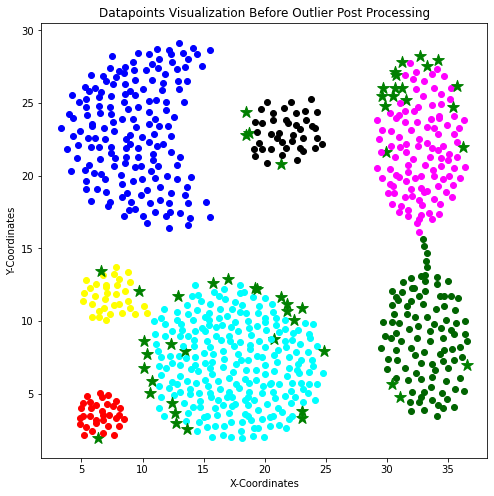

In [18]:
if Dimension <= 2:
    plt.figure(figsize=(8,8))
    
    color = ['red', 'aqua', 'yellow', 'magenta', 'black', 'darkgreen', 'blue', 'gray', 'purple', 'lime', 'maroon', 'gold', 'deeppink', 'silver', 'lawngreen', 'pink', 'navy', 'blueviolet', 'turquoise', 'dodgerblue', 'navajowhite', 'khaki', 'darkslateblue', 'darkseagreen', 'mediumvioletred', 'palevioletred', 'cornflowerblue', 'plum', 'steelblue', 'lightcoral']

    if cluster_num <= len(color):
        for i in range(len(data1)):
            if labels[i] != -1:
                plt.scatter(data1[i][0], data1[i][1], c=color[labels[i]-1])
            else:
                plt.scatter(data1[i][0],data1[i][1],c='green',marker='*',s=150)
    else:
        for i in range(len(data1)):
            if labels[i] == -1:
                plt.scatter(data1[i][0],data1[i][1],c='green',marker='*',s=150)
            else:
                plt.scatter(data1[i][0], data1[i][1],c='blue', label='Datapoints')

    plt.xlabel('X-Coordinates')
    plt.ylabel('Y-Coordinates')
    plt.title('Datapoints Visualization Before Outlier Post Processing')
    plt.show()

In [19]:
def OutlierPostProcessing(LLE_lookup, algo, data1, labels, percent5):
    # Select a predetermined value of K
    # Find the K nearest Neighbors of an outlier
    # For each of those neighbors:
    #     Find their Intracluster distance with the same K value
    #     If the Intracluster distance of outlier is within +-5% of the intracuster distance of the neighbor,
    #     and the neighbor point is not an outlier, 
    #     then consider the outlier to be a part of the smae cluster that the neighbor point belongs.
    
    ##nbrs = NearestNeighbors(n_neighbors=K, algorithm=algo).fit(data1)
    ##distances, indices = nbrs_ddcal.kneighbors(data1)
    
    for i in range(len(data1)):
        if labels[i] == -1:
            # Predicted Outlier, so find its K nearest neighbors
            #############################################################
            Opt_K = LLE_lookup[i]
            nbrs = NearestNeighbors(n_neighbors=Opt_K, algorithm=algo).fit(data1)
            _, indices = nbrs.kneighbors(data1)
            #############################################################
            
            PredOutlierNNidx = indices[i]
            PredOutlierNN = []
            for idx in PredOutlierNNidx:
                PredOutlierNN.append(data1[idx])
            # Find the intracluster distance for the Predicted Outlier
            PredOutlierICD = IntraClusterDistance(PredOutlierNN)
            # print("Outlier", i, PredOutlierICD)
            
            
            # For each of the outlier's K neighbors
            for idx in PredOutlierNNidx[1:]:
                
                # Check if the neighbor is an outlier or inlier
                if labels[idx] != -1:
                    # print("Not an Outlier")
                    NNeighboridx = indices[idx]
                    NNeighbor = []
                    for idx1 in NNeighboridx:
                        NNeighbor.append(data1[idx1])
                        
                    # Find each neighbor's IntraClusterDistance(ICD)
                    NNICD = IntraClusterDistance(NNeighbor)
                    #print("NNICD: ", NNICD)
                    
                    # Check if outlier's ICD is about +-5% of neighbor's ICD
                    # print("Lower: ",(NNICD-percent5*NNICD), "Upper: ",(NNICD+percent5*NNICD), "Self: ",PredOutlierICD)
                    if (NNICD-percent5*NNICD) <= PredOutlierICD <= (NNICD+percent5*NNICD):
                        # Change the label of the Predicted Outlier 'i' to the 
                        # label of the 1st Nearest Neighbor which satifies the condition
                        labels[i] = labels[idx]
                        # print("Changed\n")
                        break

            
def IntraClusterDistance(X):
        Intra_Clus_Dist = 0
        for i in range(len(X)):
            Intra_Clus_Dist += (sum(euclidean_distances(X, [X[i]]))[0])/(len(X)-1)
        return Intra_Clus_Dist/(len(X)-1)
    


# KVal = int(0.01*len(data1)) #5 #0.03 
percent5 = 5
OutlierPostProcessing(LLE_lookup, algo, data1, labels, percent5)

<ipython-input-19-1b3f1c740465>:59: RuntimeWarning: invalid value encountered in double_scalars
  Intra_Clus_Dist += (sum(euclidean_distances(X, [X[i]]))[0])/(len(X)-1)
<ipython-input-19-1b3f1c740465>:59: RuntimeWarning: invalid value encountered in double_scalars
  Intra_Clus_Dist += (sum(euclidean_distances(X, [X[i]]))[0])/(len(X)-1)
<ipython-input-19-1b3f1c740465>:59: RuntimeWarning: invalid value encountered in double_scalars
  Intra_Clus_Dist += (sum(euclidean_distances(X, [X[i]]))[0])/(len(X)-1)
<ipython-input-19-1b3f1c740465>:59: RuntimeWarning: invalid value encountered in double_scalars
  Intra_Clus_Dist += (sum(euclidean_distances(X, [X[i]]))[0])/(len(X)-1)
<ipython-input-19-1b3f1c740465>:59: RuntimeWarning: invalid value encountered in double_scalars
  Intra_Clus_Dist += (sum(euclidean_distances(X, [X[i]]))[0])/(len(X)-1)
<ipython-input-19-1b3f1c740465>:59: RuntimeWarning: invalid value encountered in double_scalars
  Intra_Clus_Dist += (sum(euclidean_distances(X, [X[i]]))[0

In [20]:
label_list = []
anomaly_list = []
max_val = float("-inf")
for key in labels:
    if max_val < labels[key]:
        max_val = labels[key]
    if labels[key] == -1:
        anomaly_list.append(data1[key])
    else:
        label_list.append(labels[key])
cluster_num = max_val
#print(label_list)
print("\n------------ After Outlier Post Processing ------------")
print("Total number of datapoints =", len(data1))
print("Number of Non-Anomalies =", len(label_list))
print("Number of Anomalies =", len(anomaly_list))
print("Number of Cluster(s) =", cluster_num)


------------ After Outlier Post Processing ------------
Total number of datapoints = 788
Number of Non-Anomalies = 755
Number of Anomalies = 33
Number of Cluster(s) = 7


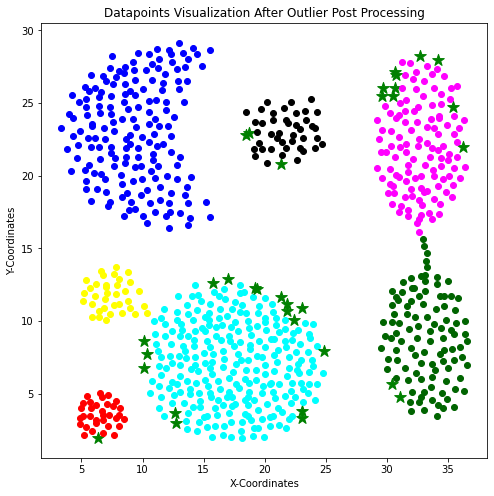

In [21]:
if Dimension <= 2:
    plt.figure(figsize=(8,8))

    color = ['red', 'aqua', 'yellow', 'magenta', 'black', 'darkgreen', 'blue', 'gray', 'purple', 'lime', 'maroon', 'gold', 'deeppink', 'silver', 'lawngreen', 'pink', 'navy', 'blueviolet', 'turquoise', 'dodgerblue', 'navajowhite', 'khaki', 'darkslateblue', 'darkseagreen', 'mediumvioletred', 'palevioletred', 'cornflowerblue', 'plum', 'steelblue', 'lightcoral']

    if cluster_num <= len(color):
        for i in range(len(data1)):
            if labels[i] != -1:
                plt.scatter(data1[i][0], data1[i][1], c=color[labels[i]-1])
            else:
                plt.scatter(data1[i][0],data1[i][1],c='green',marker='*',s=150)
    else:
        for i in range(len(data1)):
            if labels[i] == -1:
                plt.scatter(data1[i][0],data1[i][1],c='green',marker='*',s=150)
            else:
                plt.scatter(data1[i][0], data1[i][1],c='blue', label='Datapoints')

    plt.xlabel('X-Coordinates')
    plt.ylabel('Y-Coordinates')
    plt.title('Datapoints Visualization After Outlier Post Processing')
    plt.show()

In [22]:
if Clustering:
    # Performance Evaluation
    # Ground_Truth_data_path=r"E:\ISI\GROUND TRUTHS CLUSTERING\a2_gt.csv"
    with open(Ground_Truth_data_path, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        data_f = list(reader)

    # Clusters from Ground Truth Data
    clustersFromGT = []
    clustersFromGT.append(0)

    count = 1
    temp = []
    temp.append(int(data_f[0][-1]))

    for i in range(1, len(data_f)):
        if int(data_f[i][-1]) != int(data_f[i-1][-1]) and int(data_f[i][-1]) not in temp:
            temp.append(int(data_f[i][-1]))
            clustersFromGT.append(i)
            count += 1
    clustersFromGT.append(i+1)


    def EvaluateClustering(labels_PC, n_e_val_0, data_path, clustersFromGT, data1, labels_Idxs):
        with open(data_path, 'r') as f:
            reader = csv.reader(f, delimiter=',')
            data = list(reader)
            data = np.array(data).astype(float)

        d=2
        row=len(data)
        dimension=len(data[0])
        neighbors=4
        W=np.zeros((row, row))

        for i in range(row):
            D_i=np.array(data-data[i, :])
            distance=(D_i**2).sum(1)
            nearest_neighbor=np.argsort(distance)[1:(neighbors+1)]
            D_nbrs=D_i[nearest_neighbor, :]
            Q=np.dot(D_nbrs, D_nbrs.T)
            t=np.trace(Q)
            r=0.001*t
            if(neighbors>=dimension):
                Q=Q+(r*np.identity(neighbors))
            w=np.linalg.solve(Q, np.ones(neighbors))
            w=w/sum(w)
            W[i, nearest_neighbor]=w

        I=np.identity(row)
        M=I-W

        U, S, Vt = np.linalg.svd(M)
        e_val=S**2
        e_val_0=np.array(e_val<10**-20)


        uniq=np.array(np.unique(labels_PC))
        confusion_mat=np.zeros((n_e_val_0,n_e_val_0))
        status=np.zeros((len(uniq)))
        # print("\nSTATUS_INIT",status,"\n")                                                                    

        x = 0
        y = 1
        f = 0                       

        get_cluster_from_ground_truth = clustersFromGT


        while y < len(get_cluster_from_ground_truth):
            cm_k=np.zeros((n_e_val_0))
            start = get_cluster_from_ground_truth[x]
            end = get_cluster_from_ground_truth[y]
            pred_labels=labels_PC[start:end]
            f += 1
            #print(f)
            while True:
                maj_label=np.argmax(np.bincount(pred_labels))
                if(status[maj_label]!=1):
                    status[maj_label]=1
                    break
                pred_labels=pred_labels[pred_labels!=maj_label]
                if len(pred_labels) == 0:
                    break
            cl_k_k=np.count_nonzero(np.array(pred_labels==maj_label))  # True Positive
            cm_k[maj_label]=cl_k_k  
            for i in range((n_e_val_0)): # n_e_val_0 = no.of clusters in dataset ? Till now 'NO'  
                if (i != maj_label):
                    cl=np.count_nonzero(np.array(pred_labels==uniq[i]))
                    cm_k[i]=cl
            confusion_mat[maj_label, :]=cm_k
            x += 1
            y += 1

        # print(status,"\n")

        def precision(label, confusion_mat):
            col=confusion_mat[:,label]
            return confusion_mat[label, label]/col.sum()

        def recall(label, confusion_mat):
            row=confusion_mat[label,:]
            return confusion_mat[label,label]/row.sum()

        precision_arr=[]
        recall_arr=[]
        f_score=[]
        g_mean=[]
        for i in range(n_e_val_0):
            p=precision(i, confusion_mat)
            r=recall(i, confusion_mat)
            f=2*p*r/(p+r)
            g=np.sqrt(p*r)
            precision_arr=np.append(precision_arr, p)
            recall_arr=np.append(recall_arr, r)
            f_score=np.append(f_score, f)
            g_mean=np.append(g_mean, g)

        f_score = f_score[np.logical_not(np.isnan(f_score))]
        g_mean = g_mean[np.logical_not(np.isnan(g_mean))]

        f_score=np.mean(f_score)
        g_mean=np.mean(g_mean)
        accuracy=(np.trace(confusion_mat)/len(data))*100

        print("\n***************************** PERFORMANCE MEASURE *****************************")
        print("Accuracy: ",accuracy,"--------- f score:",f_score,"--------- g mean:",g_mean)
        print("DB Index =", davies_bouldin_score(data1, labels_Idxs))
        distances = pairwise_distances(data1)
        print("Dunn Index =", dunn(distances, labels_Idxs))
        print('Silhouette Score =',silhouette_score(data1, labels_Idxs))
        print('Calinski-Harabasz Index =',metrics.calinski_harabasz_score(data1, labels_Idxs))




    # Function to generate labels for getting DB, Dunn, Silhouette and Calinski-Harabasz Indexes
    def GetLabelsForIdxs(labels):
        get_labels_DB = []
        for key in labels:
            if labels[key] > 0:
                get_labels_DB.append(labels[key]-1)
            else:
                get_labels_DB.append(labels[key])
        return get_labels_DB

    # Function to generate labels for getting the accurcay, f score and g mean
    def GetLabelsForPC(labels):
        get_labels_PC = []
        for key in labels:
            if labels[key] > 0:
                get_labels_PC.append(labels[key]-1)
        return get_labels_PC


    get_labels_PC = GetLabelsForPC(labels)
    labels_PC = np.array(get_labels_PC)
    get_labels_DB = GetLabelsForIdxs(labels)
    labels_Idxs = np.array(get_labels_DB)
    EvaluateClustering(labels_PC, cluster_num, Ground_Truth_data_path, clustersFromGT, data1, labels_Idxs)

In [23]:
if Outlier_Detection:
    def OutlierDetectionEvaluation(actual_labels, pred_labels, data1, labels_Idxs):
        # confusion matrix in sklearn
        from sklearn.metrics import confusion_matrix
        from sklearn.metrics import classification_report

        # actual values
        actual = actual_labels #[1,0,0,1,0,0,1,0,0,1]
        # predicted values
        predicted = pred_labels #[1,0,0,1,0,0,0,1,0,0]

        # confusion matrix
        matrix = confusion_matrix(actual,predicted, labels=[1,0])
        #print('Confusion matrix : \n',matrix)

        # outcome values order in sklearn
        tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=[1,0]).reshape(-1)
        #print('Outcome values : \n', tp, fn, fp, tn)

        # classification report for precision, recall f1-score and accuracy
        matrix = classification_report(actual,predicted,labels=[1,0])
        print('Classification report : \n',matrix)


        print("\n")
        print("DB Index =", davies_bouldin_score(data1, labels_Idxs))
        distances = pairwise_distances(data1)
        print("Dunn Index =", dunn(distances, labels_Idxs))
        print('Silhouette Score =',silhouette_score(data1, labels_Idxs))
        print('Calinski-Harabasz Index =',metrics.calinski_harabasz_score(data1, labels_Idxs))


    def Actual_labels(Ground_Truth_data_path):
        with open(Ground_Truth_data_path, 'r') as f:
            actual_labels = np.genfromtxt(f, delimiter=',')
        return actual_labels

    def GetLabelsForOutlierDet(labels):
        get_labels_OutlierDet = []
        for key in labels:
            if labels[key] != -1:
                get_labels_OutlierDet.append(0)
            else:
                get_labels_OutlierDet.append(1)
        return get_labels_OutlierDet

    # Function to generate labels for getting DB, Dunn, Silhouette and Calinski-Harabasz Indexes
    def GetLabelsForIdxs(labels):
        get_labels_DB = []
        for key in labels:
            if labels[key] > 0:
                get_labels_DB.append(labels[key]-1)
            else:
                get_labels_DB.append(labels[key])
        return get_labels_DB


    actual_labels = Actual_labels(Ground_Truth_data_path)
    pred_labels = GetLabelsForOutlierDet(labels)
    get_labels_DB = GetLabelsForIdxs(labels)
    labels_Idxs = np.array(get_labels_DB)
    OutlierDetectionEvaluation(actual_labels, pred_labels, data1, labels_Idxs)

In [24]:
print("time taken = ",time.time()-start," sec")
#print("Average density =", sum(density)/len(data1))

time taken =  16.42689824104309  sec
